# Import and Define

In [1]:
from plot import *
import numpy as np
import pandas as pd
import polars as pl
from huggingface_hub import hf_hub_download, snapshot_download

from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()

/accounts/grad/czye/conda/envs/gpn_env/envs/gpn_star/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
palette = {
    'GPN-Star': "#2773BA",
    'PhyloP': '#9E66BA', 
    'PhastCons': '#C4494B',
}

In [3]:
# model groups

gpn_star_models = [
    'GPN-Star'
]

genome_wide_veps = [
    'PhyloP',
    'PhastCons',
]

In [4]:
WORK_DIR = 'tmp/'

# CaeNDR rare vs. common enrichment

In [5]:
snapshot_download(repo_id="songlab/caendr", local_dir=f"{WORK_DIR}/caendr", repo_type="dataset")

Fetching 6 files: 100%|██████████| 6/6 [00:01<00:00,  4.14it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/tmp/caendr'

In [6]:
V_caendr = pd.read_parquet(f'{WORK_DIR}/caendr/test.parquet')

all_models = genome_wide_veps + gpn_star_models
for m in all_models:
    V_caendr[m] = pd.read_parquet(f'{WORK_DIR}/caendr/predictions/{m}.parquet')

In [7]:
V_caendr = pl.from_pandas(V_caendr) # compute in polars for efficiency
V_caendr

chrom,pos,ref,alt,AF,AC,AN,consequence,label,PhyloP,PhastCons,GPN-Star
str,i64,str,str,f64,i64,i64,str,bool,f64,f64,f64
"""I""",855,"""G""","""C""",0.677083,390,576,"""intergenic""",false,-0.104,0.801,2.739304
"""I""",1222,"""A""","""C""",0.320248,310,968,"""intergenic""",false,-0.361,0.983,0.812919
"""I""",1761,"""G""","""A""",0.229572,236,1028,"""intergenic""",false,-0.359,0.961,1.379366
"""I""",1799,"""T""","""C""",0.210938,216,1024,"""intergenic""",false,-0.268,0.995,0.930115
"""I""",1933,"""C""","""G""",0.736842,756,1026,"""intergenic""",false,0.181,0.752,-1.178047
…,…,…,…,…,…,…,…,…,…,…,…
"""X""",17715277,"""G""","""A""",0.206133,242,1174,"""intron""",false,-0.234,0.933,-0.018484
"""X""",17715428,"""T""","""C""",0.397284,468,1178,"""intron""",false,2.305,0.998,-1.633365
"""X""",17718438,"""C""","""T""",0.286942,334,1164,"""missense""",false,-0.038,0.997,0.951009


In [8]:
results_caendr = []
for c in tqdm(V_caendr['consequence'].unique().to_list()+['all']):
    if c != 'all' and (V_caendr['consequence']==c).sum() < 500:
        continue
    df_c = V_caendr.clone() if c == "all" else V_caendr.filter(pl.col("consequence") == c)
    df_c = df_c.drop_nulls(subset=all_models)
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in all_models:
        try:
            if m not in gpn_star_models:
                # Fix: Apply negation to the score column instead of the DataFrame
                selected_df = df_c.select(["label", pl.col(m).alias("score")])
                selected_df = selected_df.with_columns(pl.col("score") * -1)
                odds_ratio = (
                    get_odds_ratio(selected_df, [30])
                    .with_columns(
                        Consequence=pl.lit(c), Model=pl.lit(m),
                        n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
                    )
                )
                results_caendr.append(odds_ratio)
            else:
                odds_ratio = (
                    get_odds_ratio(df_c.select(["label", pl.col(m).alias("score")]), [30])
                    .with_columns(
                        Consequence=pl.lit(c), Model=pl.lit(m),
                        n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg),
                    )
                )
                results_caendr.append(odds_ratio)
        except:
            pass

results_caendr = pl.concat(results_caendr).to_pandas()
results_caendr.head()

 54%|█████▍    | 7/13 [00:00<00:00, 59.28it/s]

100%|██████████| 13/13 [00:00<00:00, 60.85it/s]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,1.783885,1.798988e-03,downstream_gene,PhyloP,22533,10447
1,30,1.990893,7.547264e-36,downstream_gene,PhastCons,22533,10447
2,30,7.734132,2.935352e-50,downstream_gene,GPN-Star,22533,10447
3,30,1.807365,1.027073e-03,3_prime_UTR,PhyloP,16467,5966
4,30,2.273069,1.762452e-32,3_prime_UTR,PhastCons,16467,5966


In [9]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "splice_region": "splice-region",
    "start_or_stop": "start-or-stop",
}
results_caendr['Consequence'] = results_caendr['Consequence'].replace(replacements)

In [10]:
results_caendr = results_caendr.sort_values('Odds ratio', ascending = False)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:414: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(


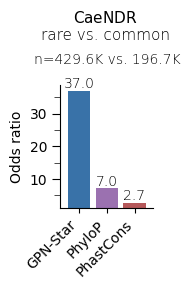

In [11]:
barplot_vertical(
    results_caendr[
        (results_caendr.p_value < 0.05) &
        (results_caendr.Consequence == "all")
    ],
    "Odds ratio",
    r"$\bf{\sf{CaeNDR}}$" + "\nrare vs. common",
    y=1.35, width=1.2, height=1.6,
    palette=palette,
)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette`

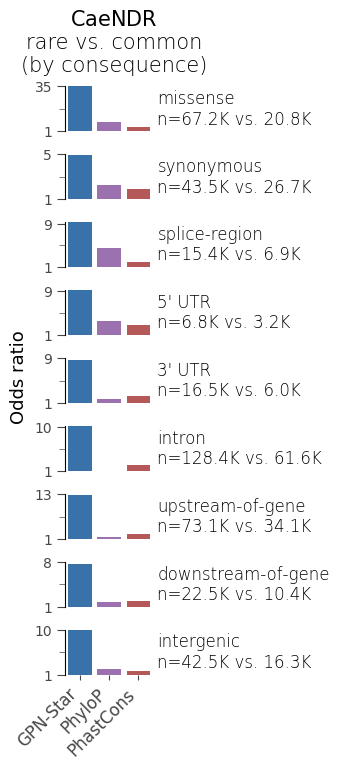

In [12]:
barplot_vertical_aligned(
    results_caendr[(results_caendr.n==30) & (results_caendr.p_value < 0.05)],
    metric="Odds ratio",
    title=r"$\bf{\sf{CaeNDR}}$" + "\nrare vs. common\n(by consequence)",
    palette=palette,
    width=1.3,
    height=0.85,
    hspace=0.5,
    suptitle_y=0.98,
    model_order=['GPN-Star', 'PhyloP', 'PhastCons',],
    group_order=['missense', 'synonymous', 'splice-region', "5' UTR", "3' UTR", 'intron', 'upstream-of-gene', 'downstream-of-gene', 'intergenic'],
)


# C. elegans lethal mutations

In [13]:
snapshot_download(repo_id="songlab/celegans_lethal", local_dir=f"{WORK_DIR}/celegans_lethal", repo_type="dataset")

Fetching 6 files: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/tmp/celegans_lethal'

In [14]:
V_lethal = pd.read_parquet(f'{WORK_DIR}/celegans_lethal/test.parquet')

for m in genome_wide_veps + gpn_star_models:
    V_lethal[m] = pd.read_parquet(f'{WORK_DIR}/celegans_lethal/predictions/{m}.parquet')
V_lethal

,chrom,pos,ref,alt,consequence,label,PhyloP,PhastCons,GPN-Star
0,III,7359885,G,A,nonsense,True,4.558,1.000,-8.100762
1,III,7360261,C,T,missense,True,20.000,1.000,-9.008378
2,III,8169268,G,A,nonsense,True,20.000,1.000,-11.086087
3,III,8166973,G,A,nonsense,True,20.000,1.000,-10.436231
4,III,4943615,C,T,missense,True,20.000,1.000,-9.713968
...,...,...,...,...,...,...,...,...,...
22178,X,17560245,A,T,missense,False,2.599,1.000,11.233121
22179,X,17651542,T,C,missense,False,2.414,0.967,4.859400
22180,X,17651562,T,A,missense,False,3.552,1.000,-8.062285
22181,X,17718438,C,T,missense,False,-0.038,0.997,0.951009


In [15]:
all_models = genome_wide_veps + gpn_star_models
rows = []
V_lethal_c = V_lethal.copy()
V_lethal_c.dropna(subset=all_models, inplace=True)
V_lethal_c.reset_index(drop=True, inplace=True)
n_pos, n_neg = (V_lethal_c.label==True).sum(), (V_lethal_c.label==False).sum()
pos_prop = n_pos/(n_pos+n_neg)

print("Calculating AUROC and AUPRC with 1000 bootstraps...")
for m in tqdm(all_models, desc='models'):
    if m in gpn_star_models:
        AUROC = roc_auc_score(V_lethal_c.label==True, -V_lethal_c[m])
        AUPRC = average_precision_score(V_lethal_c.label==True, -V_lethal_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_lethal_c.label==True, -V_lethal_c[m])
    else:
        AUROC = roc_auc_score(V_lethal_c.label==True, V_lethal_c[m])
        AUPRC = average_precision_score(V_lethal_c.label==True, V_lethal_c[m])
        AUROC_se, AUPRC_se = stratified_bootstrap_se(V_lethal_c.label==True, V_lethal_c[m])
    rows.append([m, AUROC, AUPRC, AUROC_se, AUPRC_se])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC", "AUROC_se", "AUPRC_se"])
results = results.sort_values('AUPRC', ascending = False)
results

Calculating AUROC and AUPRC with 1000 bootstraps...


models: 100%|██████████| 3/3 [00:29<00:00,  9.70s/it]


,Model,AUROC,AUPRC,AUROC_se,AUPRC_se
2,GPN-Star,0.990474,0.727862,0.006196,0.053063
0,PhyloP,0.949954,0.268858,0.015553,0.040208
1,PhastCons,0.893505,0.023937,0.019754,0.001735


/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


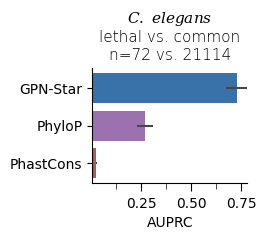

In [16]:
barplot(
    results,
    "AUPRC",
    pos_prop = pos_prop,
    palette = palette,
    figsize=(2,1.5),
    title = r'$\it{C.\ elegans\ }$' + f"\nlethal vs. common\nn={n_pos} vs. {n_neg}",
)